In [1]:
SF = 10
schema = f'CH{SF:02d}'
ssd_cache    = True


In [2]:
### for testing keep it False
result_cache = False

**<mark><u>Import</u></mark>**

In [3]:
import duckdb
import pathlib
from   deltalake import convert_to_deltalake, DeltaTable
import time
import pandas as pd
from   deltalake.writer import write_deltalake
from   datetime import datetime
from   sqlglot import parse_one, exp
from   psutil import *
from   cachetools import cached, LRUCache

In [4]:
core=cpu_count()
core

2

# Generate Delta

In [5]:
%%time
Table_Path = '/lakehouse/default/Tables'
if not pathlib.Path(f'{Table_Path}/CH{SF:02d}').exists():
  for x in range(0, SF) :
    con=duckdb.connect()
    con.sql(f"CALL dbgen(sf={SF} , children ={SF}, step = {x})")
    for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
        pathlib.Path(f'{Table_Path}/CH{SF:02d}/{tbl}').mkdir(parents=True, exist_ok=True)
        con.sql(f"""  COPY (SELECT * FROM {tbl}) TO '{Table_Path}/CH{SF:02d}/{tbl}' (FORMAT PARQUET,PER_THREAD_OUTPUT TRUE,APPEND) """)
    con.close()
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
      convert_to_deltalake(f'{Table_Path}/CH{SF:02d}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
else:
  print("Already Generated")

Already Generated
CPU times: user 855 µs, sys: 158 µs, total: 1.01 ms
Wall time: 240 ms


<mark>**Initiate an Empty Local DB**</mark>

In [6]:
con = duckdb.connect(f'temp_CH{schema}.duckdb')
con.sql('SET preserve_insertion_order=false')
con.sql(""" create table if not exists delta(tbl string , version int,id string PRIMARY KEY) """)

# SQL Query

In [7]:
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price
FROM
    lineitem
WHERE
    l_shipdate > CAST('1998-05-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
	o_orderpriority,
	count(*) as order_count
from
	orders
where
	o_orderdate >= cast('1993-07-01' as date)
	and o_orderdate < cast('1993-10-01' as date)
	and o_orderkey in (
		select
			l_orderkey
		from
			lineitem
		where
			l_commitdate < l_receiptdate
	)
group by
	o_orderpriority
order by
	o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    ps.ps_partkey,
    SUM(ps.ps_supplycost * ps.ps_availqty) AS value
FROM
    partsupp ps
JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    n.n_name = 'GERMANY'
GROUP BY
    ps.ps_partkey
HAVING
    SUM(ps.ps_supplycost * ps.ps_availqty) > (
        SELECT
            SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
        FROM
            partsupp ps_inner
        JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
        JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
        WHERE
            n_inner.n_name = 'GERMANY'
    )
ORDER BY
    value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
		p_brand = 'Brand#12'
		and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
		and l_quantity >= 1 and l_quantity <= 1 + 10
		and p_size between 1 and 5
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#23'
		and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
		and l_quantity >= 10 and l_quantity <= 10 + 10
		and p_size between 1 and 10
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#34'
		and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
		and l_quantity >= 20 and l_quantity <= 20 + 10
		and p_size between 1 and 15
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	);





--Query20
with availability_part_supp as(
	    select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
	    from lineitem
	    where l_shipdate >= cast('1994-01-01' as date)
	    and l_shipdate < cast('1995-01-01' as date)
	    group by pkey, skey
)
select s_name, s_address
from supplier, nation
where s_suppkey in (
	    select ps_suppkey
	    from partsupp, availability_part_supp
	    where ps_partkey in (
		        select p_partkey
			        from part
				        where p_name like 'forest%'
					    )
					    and ps_partkey = pkey
					    and ps_suppkey = skey
					    and ps_availqty > ps_halfqty
				)
				and s_nationkey = n_nationkey
				and n_name = 'CANADA'
				order by s_name;






SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





select
--Query22
cntrycode,
	count(*) as numcust,
	sum(c_acctbal) as totacctbal
from ( select
			substring(c_phone from 1 for 2) as cntrycode,
			c_acctbal
		from customer
		where substring(c_phone from 1 for 2) in
				('13', '31', '23', '29', '30', '18', '17')
			and c_acctbal > (
				select avg(c_acctbal)
				from customer
				where c_acctbal > 0
					and substring(c_phone from 1 for 2) in
						('13', '31', '23', '29', '30', '18', '17')
			)
			and c_custkey not in (
				select o_custkey
				from orders
			)
	) as custsale
group by cntrycode
order by cntrycode;

SELECT
    --Query01
    l_returnflag,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1997-09-02' AS date)
GROUP BY ALL ;


SELECT 
    c.c_custkey, 
    c.c_name, 
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue
FROM 
    customer c
INNER JOIN 
    orders o ON c.c_custkey = o.o_custkey
INNER JOIN 
    lineitem l ON o.o_orderkey = l.l_orderkey
GROUP BY 
    c.c_custkey, c.c_name
ORDER BY 
    revenue DESC
LIMIT 10;


SELECT 
    o.o_orderkey, 
    o.o_orderdate, 
    c.c_name, 
    c.c_phone
FROM 
    orders o
LEFT JOIN 
    lineitem l ON o.o_orderkey = l.l_orderkey AND l.l_shipdate IS NOT NULL
INNER JOIN 
    customer c ON o.o_custkey = c.c_custkey
WHERE 
    l.l_shipdate IS NULL;







''')

# Utility Function

In [8]:
def disk_cache(sql_query):
    if ssd_cache is True :
        tbl_type ='table'
    else:
        tbl_type ='view'
    start = time.time()
    print(tbl_type)
    data =[]
    tbl_list = [table.name for table in parse_one(sql_query).find_all(exp.Table)]
    tbl_list = sorted(list(set(tbl_list))) # remove duplicate
    for tbl in tbl_list :
            try :
                dt = DeltaTable(f'/lakehouse/default/Tables/{schema}/{tbl}')
                version =dt.version()
                table_id = dt.metadata().id
                data.append({'tbl': tbl, 'version': version,'id':table_id})
            except  Exception as er:
              print(f"this table is a CTE :{tbl}")         
    deltaonelake = pd.DataFrame(data)

    result =con.sql(" select tbl, version, id from deltaonelake where concat(id,cast (id as string))  not in (select concat(id,cast (id as string)) from delta)").fetchall()
    if len(result)==0:
        print ('all cacheed')
    else:
        for tbl, version, id in result:
            print(f"caching {tbl}")
            con.sql(f''' CREATE or replace {tbl_type}  {tbl} AS SELECT * FROM delta_scan('/lakehouse/default/Tables/{schema}/{tbl}') ''')
            con.sql(f''' INSERT OR REPLACE INTO delta VALUES ('{tbl}',{version}, '{id}'); ''')
            print(f"done")
        con.sql('checkpoint ;')
    print('sync to disk: ' + str(time.time()-start))
    return  ' '.join(deltaonelake.stack().astype(str))

In [9]:
if result_cache is True :
    @cached(cache=LRUCache(maxsize=32))
    def run_one_query(sql,metadata):
      return con.sql(sql).show()
else:
    def run_one_query(sql,metadata):
       return con.sql(sql).show()

In [10]:
def execute_multiplequery(sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            metadata = disk_cache(value)
            result = run_one_query(value,metadata)
            display(result)
            duration = time.time()-start
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

In [11]:
def run_test(sql):
    df=execute_multiplequery(sql)
    df['Engine']        = 'duckdb'
    df['disk_cache']    = ssd_cache
    df['result_cache']  = result_cache
    df['time']          = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df['sf']            = SF
    df['cpu']           = core
    df['test']          = 'tpch'
    write_deltalake('/lakehouse/default/Tables/dbo/duckdbresult',df,mode="append",storage_options={"allow_unsafe_rename":"true"},engine='rust') 
    return "done"

# Run Tests

In [12]:
%%time
run_test(sql)

Query1
table
caching lineitem


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
sync to disk: 87.43166017532349


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

all cacheed
sync to disk: 0.4579133987426758
┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬──────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │       avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │        double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │   0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │  0.04997336773765667 │      385998 │
│ N            │ O            │  764635193.00 │ … │  38233.85393406864 │ 0.050001036755154445 │    29987794 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │  0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴───

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
caching partsupp


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
caching region
done
caching supplier
done
sync to disk: 19.29149293899536
┌───────────────┬────────────────────┬─────────┬───┬──────────────────────┬─────────────────┬──────────────────────┐
│   s_acctbal   │       s_name       │ n_name  │ … │      s_address       │     s_phone     │      s_comment       │
│ decimal(15,2) │      varchar       │ varchar │   │       varchar        │     varchar     │       varchar        │
├───────────────┼────────────────────┼─────────┼───┼──────────────────────┼─────────────────┼──────────────────────┤
│       9994.37 │ Supplier#000030084 │ GERMANY │ … │ Lpmw8Ht4rC,xjMQ0p5…  │ 17-519-171-6883 │ thely express inst…  │
│       9992.54 │ Supplier#000099650 │ RUSSIA  │ … │ u8irlfFJRKkGmndVKa…  │ 32-971-481-2533 │ ironic ideas. spec…  │
│       9987.51 │ Supplier#000020657 │ ROMANIA │ … │ XBf0Sq7X2xE0ZTakAq…  │ 29-167-460-7830 │  unusual requests …  │
│       9986.40 │ Supplier#000082995 │ RUSSIA  │ … │ p3Ipd2Un6pIK2        │ 32-510-919-3096 │ e packag

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
caching orders


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

done
sync to disk: 25.742266416549683
┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int64    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│    4791171 │   440715.2185 │ 1995-02-23  │              0 │
│   46678469 │   439855.3250 │ 1995-01-27  │              0 │
│   23906758 │   432728.5737 │ 1995-03-14  │              0 │
│   23861382 │   428739.1368 │ 1995-03-09  │              0 │
│   59393639 │   426036.0662 │ 1995-02-12  │              0 │
│    3355202 │   425100.6657 │ 1995-03-04  │              0 │
│    9806272 │   425088.0568 │ 1995-03-13  │              0 │
│   22810436 │   423231.9690 │ 1995-01-02  │              0 │
│   16384100 │   421478.7294 │ 1995-03-02  │              0 │
│   52974151 │   415367.1195 │ 1995-02-05  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                       

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬──────────────────┐
│  n_name   │     revenue      │
│  varchar  │  decimal(38,4)   │
├───────────┼──────────────────┤
│ INDIA     │ 13463205541.8657 │
│ VIETNAM   │ 13214757774.7194 │
│ JAPAN     │ 13213152837.6414 │
│ CHINA     │ 13209117920.7012 │
│ INDONESIA │ 13133375012.1835 │
└───────────┴──────────────────┘

3.370790481567383
Query8
table
all cacheed
sync to disk: 0.03120732307434082
┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1230113636.0101 │
└─────────────────┘

0.5782885551452637
Query9
table
all cacheed
sync to disk: 0.08537817001342773


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1992 │ 444143482.5332 │
│ FRANCE      │ GERMANY     │   1993 │ 520373495.5419 │
│ FRANCE      │ GERMANY     │   1994 │ 527796618.1738 │
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ FRANCE      │ GERMANY     │   1997 │ 523657416.0175 │
│ FRANCE      │ GERMANY     │   1998 │ 395488618.5426 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

5.101903438568115
Query10
table
all cacheed
sync to disk: 0.11297345161437988
┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

3.216099739074707
Query16
table
all cacheed
sync to disk: 0.04757380485534668
┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

0.8299136161804199
Query17
table
all cacheed
sync to disk: 0.047487735748291016
┌───────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 3295493.512857143 │
└───────────────────┘

4.872954607009888
Query20
table
all cacheed
sync to disk: 0.058851003646850586


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬───────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l.l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │   decimal(38,2)   │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼───────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │            318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │            304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │            322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │            312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │            327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │            327.00 │
│ Customer#001492954

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────────────────┐
│       s_name       │             s_address              │
│      varchar       │              varchar               │
├────────────────────┼────────────────────────────────────┤
│ Supplier#000000020 │ JtPqm19E7tF 152Rl1wQZ8j0H          │
│ Supplier#000000285 │ q TMZEDyZtv vUiFKBhT3NJlnIxpL      │
│ Supplier#000000358 │ 6XtuJkJj83BcCOV7bwV7wG5nkhazk      │
│ Supplier#000000361 │ MSi62aEN53KaoRAiaH4GEo3EsKMXSwpPGU │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo         │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke      │
│ Supplier#000000688 │ orLvVDOBBE2B2ppjbiTZTJoIJgn1VgKg3  │
│ Supplier#000000729 │ CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI │
│ Supplier#000000744 │ WdgxvW4WEloeapP7H6cWHrGLCHkStwrM   │
│ Supplier#000000752 │ GrOjezmDCNvHXl5                    │
│         ·          │        ·                           │
│         ·          │        ·                           │
│         ·          │        ·         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

6.8329641

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┐
│ c_custkey │       c_name       │    revenue    │
│   int64   │      varchar       │ decimal(38,4) │
├───────────┼────────────────────┼───────────────┤
│    694366 │ Customer#000694366 │  6882192.4328 │
│    317698 │ Customer#000317698 │  6805656.5108 │
│    750415 │ Customer#000750415 │  6683960.2270 │
│    359587 │ Customer#000359587 │  6668636.6237 │
│    571483 │ Customer#000571483 │  6658596.1866 │
│    910705 │ Customer#000910705 │  6643388.3428 │
│    998602 │ Customer#000998602 │  6602110.6615 │
│    135679 │ Customer#000135679 │  6594164.8513 │
│     22999 │ Customer#000022999 │  6553378.0866 │
│     84427 │ Customer#000084427 │  6551636.2827 │
├───────────┴────────────────────┴───────────────┤
│ 10 rows                              3 columns │
└────────────────────────────────────────────────┘

8.343806266784668
Query27
table
all cacheed
sync to disk: 0.05261039733886719


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────────┬─────────┬─────────┐
│ o_orderkey │ o_orderdate │ c_name  │ c_phone │
│   int64    │    date     │ varchar │ varchar │
├────────────┴─────────────┴─────────┴─────────┤
│                    0 rows                    │
└──────────────────────────────────────────────┘

4.095136404037476
rr /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/_commit_66ca4361-5568-4b61-bae8-5f4565245de0.json.tmp -> /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/00000000000000000007.json
CPU times: user 5min 15s, sys: 12.3 s, total: 5min 28s
Wall time: 3min 24s


'done'

In [13]:
%%time
run_test(sql)

Query1
table
all cacheed
sync to disk: 0.03130817413330078


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬──────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │       avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │        double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │   0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │  0.04997336773765667 │      385998 │
│ N            │ O            │  764635193.00 │ … │  38233.85393406864 │ 0.050001036755154445 │    29987794 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │  0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴──────────────────────┴─────────────┤
│ 4 rows  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬──────────────────┐
│  n_name   │     revenue      │
│  varchar  │  decimal(38,4)   │
├───────────┼──────────────────┤
│ INDIA     │ 13463205541.8657 │
│ VIETNAM   │ 13214757774.7194 │
│ JAPAN     │ 13213152837.6414 │
│ CHINA     │ 13209117920.7012 │
│ INDONESIA │ 13133375012.1835 │
└───────────┴──────────────────┘

3.4938595294952393
Query8
table
all cacheed
sync to disk: 0.02223682403564453
┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1230113636.0101 │
└─────────────────┘

0.6511061191558838
Query9
table
all cacheed
sync to disk: 0.09766864776611328


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1992 │ 444143482.5332 │
│ FRANCE      │ GERMANY     │   1993 │ 520373495.5419 │
│ FRANCE      │ GERMANY     │   1994 │ 527796618.1738 │
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ FRANCE      │ GERMANY     │   1997 │ 523657416.0175 │
│ FRANCE      │ GERMANY     │   1998 │ 395488618.5426 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

5.52806282043457
Query10
table
all cacheed
sync to disk: 0.31949734687805176
┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   19

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

3.1094846725463867
Query16
table
all cacheed
sync to disk: 0.048650264739990234
┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

0.8248605728149414
Query17
table
all cacheed
sync to disk: 0.04155755043029785
┌──────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 3295493.512857143 │
└───────────────────┘

4.632424831390381
Query20
table
all cacheed
sync to disk: 0.08856630325317383


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬───────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l.l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │   decimal(38,2)   │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼───────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │            318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │            304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │            322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │            312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │            327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │            327.00 │
│ Customer#001492954

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────────────────┐
│       s_name       │             s_address              │
│      varchar       │              varchar               │
├────────────────────┼────────────────────────────────────┤
│ Supplier#000000020 │ JtPqm19E7tF 152Rl1wQZ8j0H          │
│ Supplier#000000285 │ q TMZEDyZtv vUiFKBhT3NJlnIxpL      │
│ Supplier#000000358 │ 6XtuJkJj83BcCOV7bwV7wG5nkhazk      │
│ Supplier#000000361 │ MSi62aEN53KaoRAiaH4GEo3EsKMXSwpPGU │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo         │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke      │
│ Supplier#000000688 │ orLvVDOBBE2B2ppjbiTZTJoIJgn1VgKg3  │
│ Supplier#000000729 │ CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI │
│ Supplier#000000744 │ WdgxvW4WEloeapP7H6cWHrGLCHkStwrM   │
│ Supplier#000000752 │ GrOjezmDCNvHXl5                    │
│         ·          │        ·                           │
│         ·          │        ·                           │
│         ·          │        ·         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

6.7474720

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┐
│ c_custkey │       c_name       │    revenue    │
│   int64   │      varchar       │ decimal(38,4) │
├───────────┼────────────────────┼───────────────┤
│    694366 │ Customer#000694366 │  6882192.4328 │
│    317698 │ Customer#000317698 │  6805656.5108 │
│    750415 │ Customer#000750415 │  6683960.2270 │
│    359587 │ Customer#000359587 │  6668636.6237 │
│    571483 │ Customer#000571483 │  6658596.1866 │
│    910705 │ Customer#000910705 │  6643388.3428 │
│    998602 │ Customer#000998602 │  6602110.6615 │
│    135679 │ Customer#000135679 │  6594164.8513 │
│     22999 │ Customer#000022999 │  6553378.0866 │
│     84427 │ Customer#000084427 │  6551636.2827 │
├───────────┴────────────────────┴───────────────┤
│ 10 rows                              3 columns │
└────────────────────────────────────────────────┘

8.27023696899414
Query27
table
all cacheed
sync to disk: 0.05384325981140137


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────────┬─────────┬─────────┐
│ o_orderkey │ o_orderdate │ c_name  │ c_phone │
│   int64    │    date     │ varchar │ varchar │
├────────────┴─────────────┴─────────┴─────────┤
│                    0 rows                    │
└──────────────────────────────────────────────┘

3.7723300457000732
rr /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/_commit_f1dee354-c946-40b3-84b0-6764c4a58957.json.tmp -> /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/00000000000000000008.json
CPU times: user 2min 1s, sys: 4.64 s, total: 2min 6s
Wall time: 1min 10s


'done'

In [14]:
%%time
run_test(sql)

Query1
table
all cacheed
sync to disk: 0.022746801376342773


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬──────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │       avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │        double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │   0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │  0.04997336773765667 │      385998 │
│ N            │ O            │  764635193.00 │ … │  38233.85393406864 │ 0.050001036755154445 │    29987794 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │  0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴──────────────────────┴─────────────┤
│ 4 rows  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬──────────────────┐
│  n_name   │     revenue      │
│  varchar  │  decimal(38,4)   │
├───────────┼──────────────────┤
│ INDIA     │ 13463205541.8657 │
│ VIETNAM   │ 13214757774.7194 │
│ JAPAN     │ 13213152837.6414 │
│ CHINA     │ 13209117920.7012 │
│ INDONESIA │ 13133375012.1835 │
└───────────┴──────────────────┘

3.331331253051758
Query8
table
all cacheed
sync to disk: 0.044489145278930664
┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1230113636.0101 │
└─────────────────┘

0.594923734664917
Query9
table
all cacheed
sync to disk: 0.08965373039245605


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1992 │ 444143482.5332 │
│ FRANCE      │ GERMANY     │   1993 │ 520373495.5419 │
│ FRANCE      │ GERMANY     │   1994 │ 527796618.1738 │
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ FRANCE      │ GERMANY     │   1997 │ 523657416.0175 │
│ FRANCE      │ GERMANY     │   1998 │ 395488618.5426 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

4.871426343917847
Query10
table
all cacheed
sync to disk: 0.11789560317993164
┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

3.164351463317871
Query16
table
all cacheed
sync to disk: 0.0360105037689209
┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

0.8409922122955322
Query17
table
all cacheed
sync to disk: 0.0394132137298584
┌───────────┬──

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 3295493.512857143 │
└───────────────────┘

4.543296813964844
Query20
table
all cacheed
sync to disk: 0.12035322189331055


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬───────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l.l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │   decimal(38,2)   │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼───────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │            318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │            304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │            322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │            312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │            327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │            327.00 │
│ Customer#001492954

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────────────────┐
│       s_name       │             s_address              │
│      varchar       │              varchar               │
├────────────────────┼────────────────────────────────────┤
│ Supplier#000000020 │ JtPqm19E7tF 152Rl1wQZ8j0H          │
│ Supplier#000000285 │ q TMZEDyZtv vUiFKBhT3NJlnIxpL      │
│ Supplier#000000358 │ 6XtuJkJj83BcCOV7bwV7wG5nkhazk      │
│ Supplier#000000361 │ MSi62aEN53KaoRAiaH4GEo3EsKMXSwpPGU │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo         │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke      │
│ Supplier#000000688 │ orLvVDOBBE2B2ppjbiTZTJoIJgn1VgKg3  │
│ Supplier#000000729 │ CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI │
│ Supplier#000000744 │ WdgxvW4WEloeapP7H6cWHrGLCHkStwrM   │
│ Supplier#000000752 │ GrOjezmDCNvHXl5                    │
│         ·          │        ·                           │
│         ·          │        ·                           │
│         ·          │        ·         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

6.7946763

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┐
│ c_custkey │       c_name       │    revenue    │
│   int64   │      varchar       │ decimal(38,4) │
├───────────┼────────────────────┼───────────────┤
│    694366 │ Customer#000694366 │  6882192.4328 │
│    317698 │ Customer#000317698 │  6805656.5108 │
│    750415 │ Customer#000750415 │  6683960.2270 │
│    359587 │ Customer#000359587 │  6668636.6237 │
│    571483 │ Customer#000571483 │  6658596.1866 │
│    910705 │ Customer#000910705 │  6643388.3428 │
│    998602 │ Customer#000998602 │  6602110.6615 │
│    135679 │ Customer#000135679 │  6594164.8513 │
│     22999 │ Customer#000022999 │  6553378.0866 │
│     84427 │ Customer#000084427 │  6551636.2827 │
├───────────┴────────────────────┴───────────────┤
│ 10 rows                              3 columns │
└────────────────────────────────────────────────┘

8.209061622619629
Query27
table
all cacheed
sync to disk: 0.29849791526794434


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────────┬─────────┬─────────┐
│ o_orderkey │ o_orderdate │ c_name  │ c_phone │
│   int64    │    date     │ varchar │ varchar │
├────────────┴─────────────┴─────────┴─────────┤
│                    0 rows                    │
└──────────────────────────────────────────────┘

4.218951940536499
rr /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/_commit_e620ddc0-55a5-45e8-8358-23d691beb6ef.json.tmp -> /synfs/lakehouse/default/Tables/dbo/duckdbresult/_delta_log/00000000000000000009.json
CPU times: user 2min 1s, sys: 4.62 s, total: 2min 6s
Wall time: 1min 10s


'done'

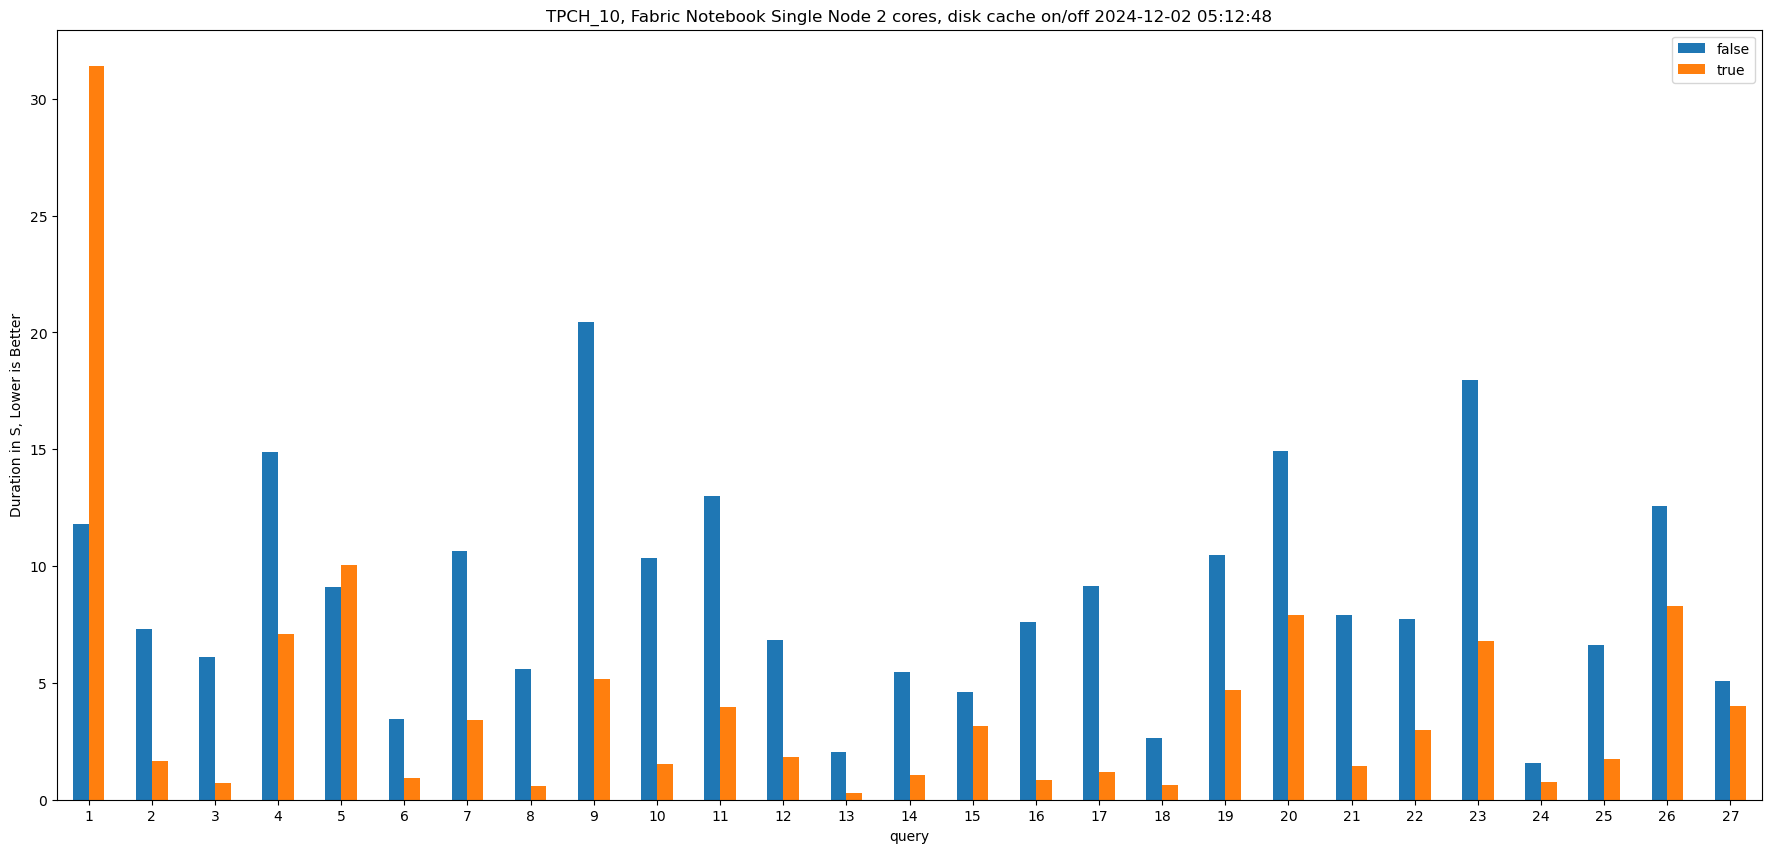

In [15]:
pv = duckdb.sql(f"""PIVOT ( select disk_cache,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch') ON disk_cache using avg(dur) order by query""")
xx = duckdb.sql(f" select query, sum(COLUMNS(*exclude(sf,query))) from pv  group by all order by query  ").df()
ax = xx.plot.bar(rot=0,x='query',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, disk cache on/off " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'),ylabel='Duration in S, Lower is Better',figsize=(22,10))

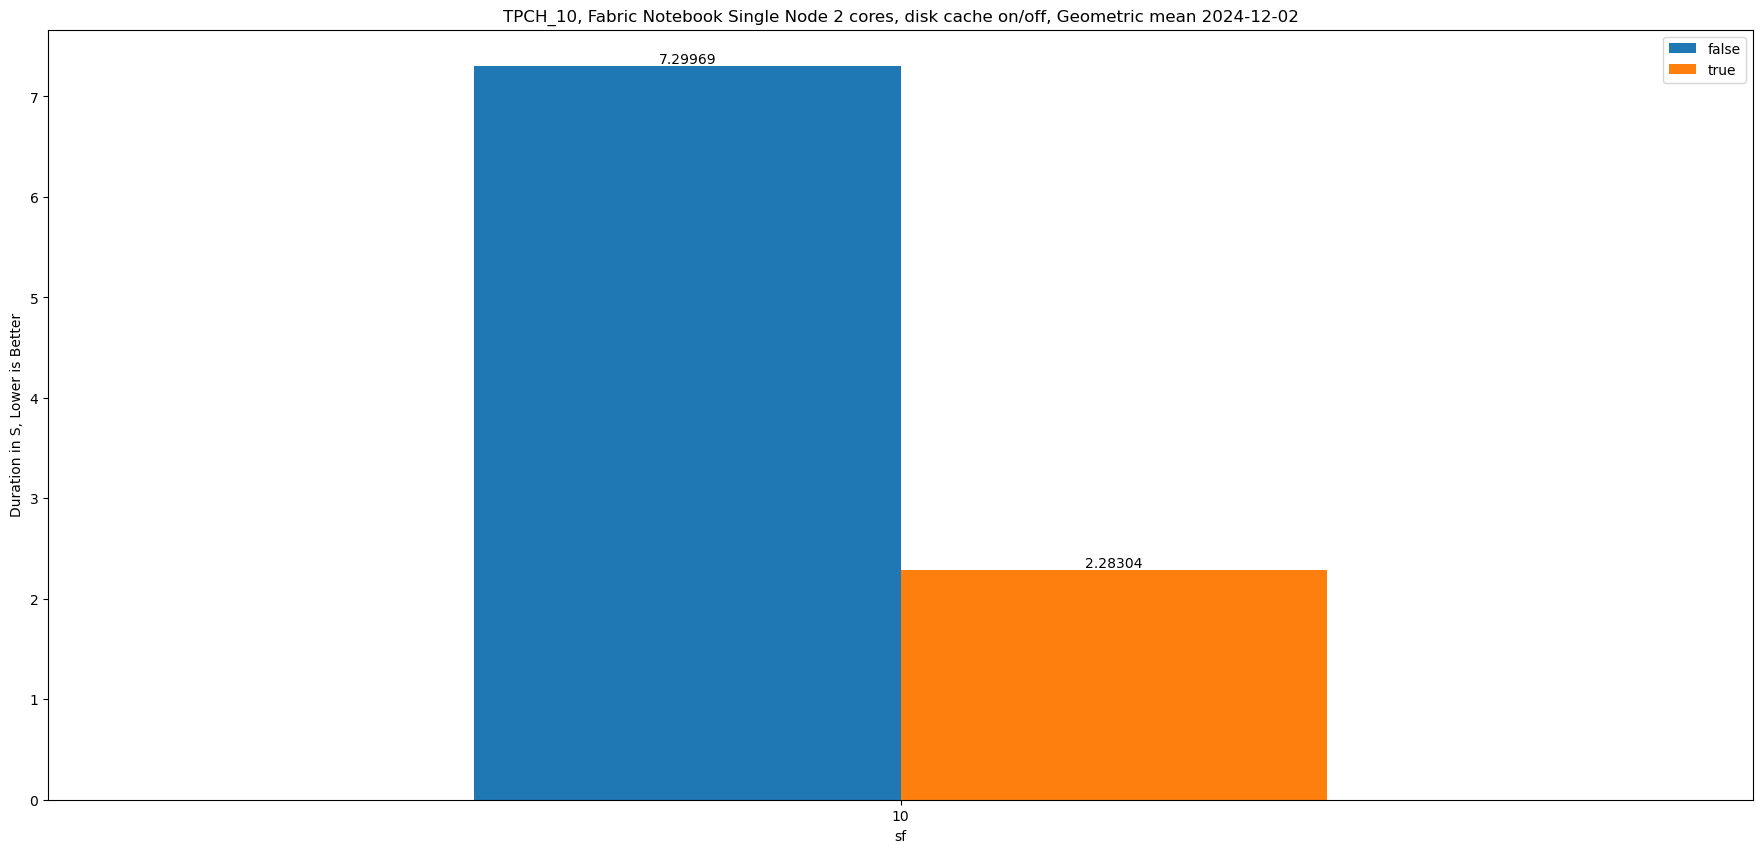

In [16]:
pv = duckdb.sql(f"""PIVOT ( select disk_cache,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON disk_cache using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, geomean(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, disk cache on/off, Geometric mean " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

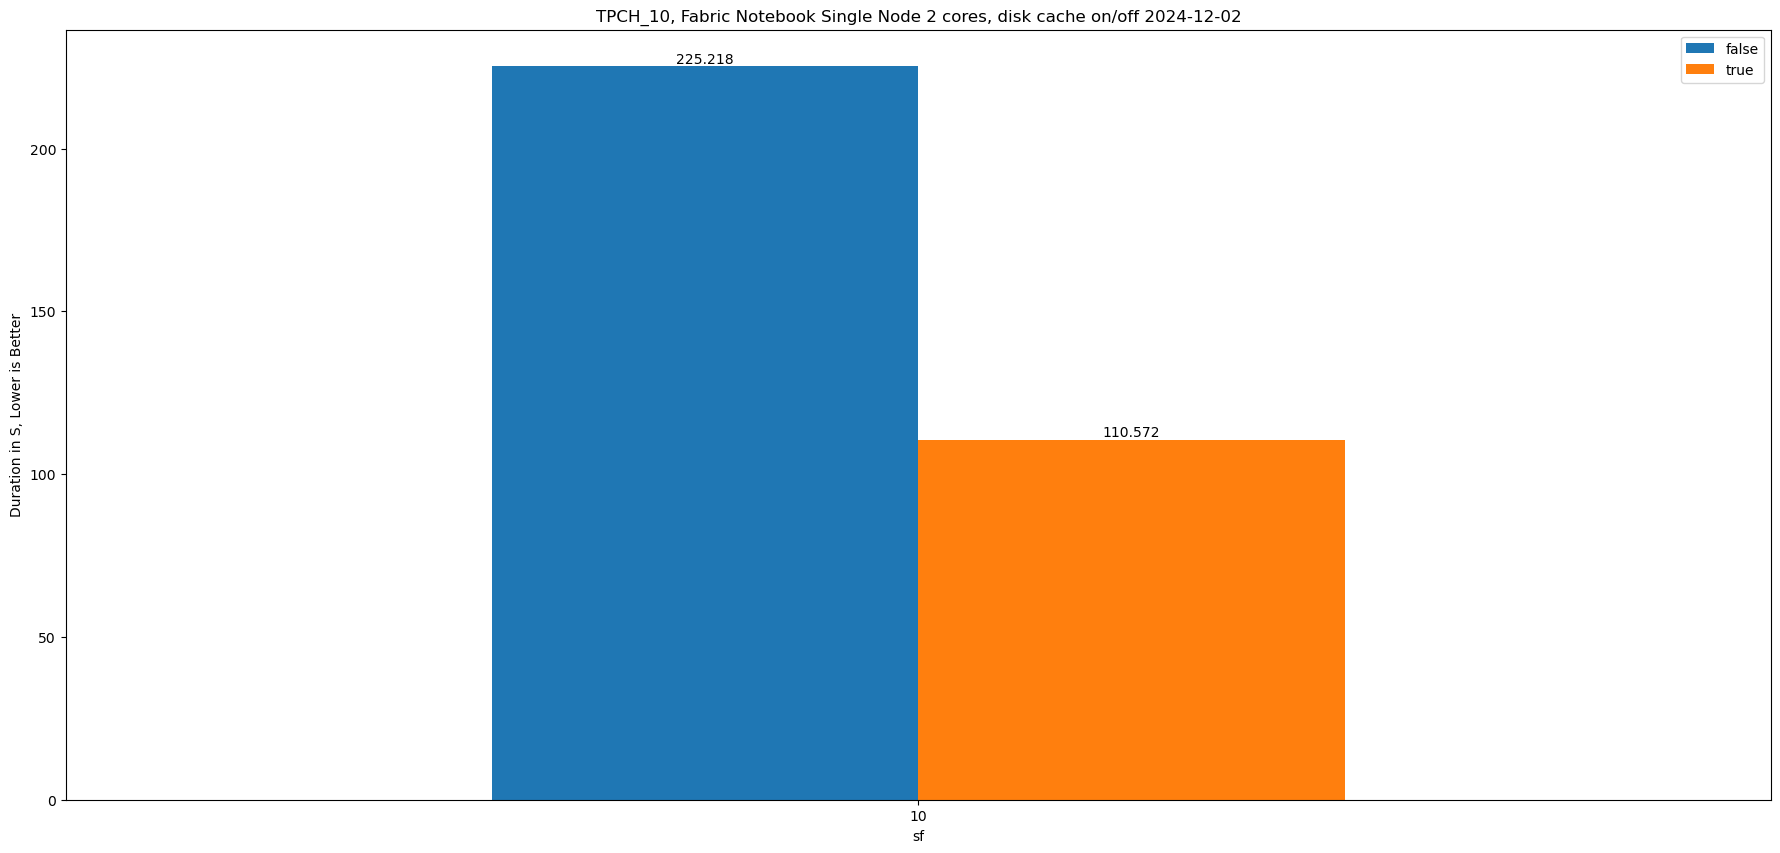

In [17]:
pv = duckdb.sql(f"""PIVOT ( select disk_cache,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/duckdbresult' ) where sf = {SF} and test  ='tpch' and query !=7 ) ON disk_cache using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, sum(COLUMNS(*exclude(sf,query))) from pv  group by all  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, disk cache on/off " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')